In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=2, hidden_size=10, num_hidden_layers=1, output_size=1):
        super(NeuralNetwork, self).__init__()

        # Create a list to store all layers
        layers = []

        # First layer (input to the first hidden layer)
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Add hidden layers (number of hidden layers is flexible)
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            #layers.append(nn.ReLU())
            layers.append(nn.Softplus(100))

        # Output layer (from the last hidden layer to the output)
        layers.append(nn.Linear(hidden_size, output_size))

        # Combine the layers into a sequential model
        self.network = nn.Sequential(*layers)

    def forward(self, coords):
        return self.network(coords)

In [3]:
def generate_data(num_samples,fun_num = 0):
    if fun_num == 0: # circle
        # Generate random (x, y) coordinates between -1 and 1
        x = torch.rand(num_samples, 2) * 2 - 1  # Range [-1, 1]
        # Compute the target function: 1 - x^2 - y^2
        y = 1 - x[:, 0] ** 2 - x[:, 1] ** 2
        return x, y.view(-1, 1)
    else:
        raise NotImplementedError


In [4]:
import matplotlib.pyplot as plt
def plotDisctancefunction(eval_fun, N=500):
    x_values = np.linspace(-1.1, 1.1, N)
    y_values = np.linspace(-1.1, 1.1, N)
    X, Y = np.meshgrid(x_values, y_values)
    Z = np.zeros((N,N))
    # Evaluate the function at each point in the grid
    for idxx, xx in enumerate(x_values):
        for idxy,yy in enumerate(y_values):
            #print(yy)
            try:
                crd = torch.tensor([xx, yy], dtype=torch.float32)
                ans = eval_fun(crd)
                Z[idxy, idxx] = ans[0].item()
            except:
                Z[idxy, idxx] = eval_fun([xx,yy])

    #Z = distanceFromContur(X, Y)

    # Create a contour plot
    plt.contourf(X, Y, Z,levels=20)
    plt.colorbar(label='f(x, y)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Scalar-Valued Function f(x, y)')
    plt.grid(True)
    plt.show()

In [5]:
relu_model = NeuralNetwork(2,256,2,1)
total_steps = 500
steps_til_summary = total_steps/10

optim = torch.optim.Adam(lr=1e-3, params=relu_model.parameters())






In [6]:
for step in range(total_steps):
    model_input, ground_truth = generate_data(10000,0)
    model_output = relu_model(model_input)
    loss = ((model_output - ground_truth)**2).mean()


    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

    optim.zero_grad()
    loss.backward()
    optim.step()
print("Step %d, Total loss %0.6f" % (step, loss))

Step 0, Total loss 0.253936
Step 50, Total loss 0.000827
Step 100, Total loss 0.000094
Step 150, Total loss 0.000048
Step 200, Total loss 0.000027
Step 250, Total loss 0.000019
Step 300, Total loss 0.000014
Step 350, Total loss 0.000010
Step 400, Total loss 0.000008
Step 450, Total loss 0.000007
Step 499, Total loss 0.000006


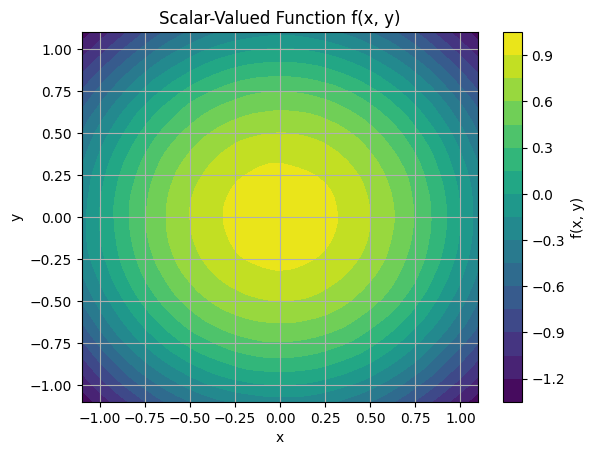

In [7]:
plotDisctancefunction(relu_model,100)

In [21]:
import datetime
date=datetime.datetime.now()
print(date.strftime('%b'),date.strftime('%d') ,"-",  date.strftime('%X'))
#torch.save(relu_model.state_dict(), f"relu_model{date.strftime('%b')}-{date.strftime('%d')}-{date.strftime('%X')}.pth")
torch.save(relu_model.state_dict(), "relu_model_last.pth")

Sep 28 - 21:14:22


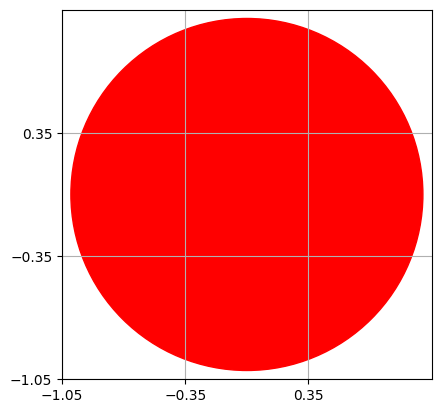

In [8]:
import NURBS
import numpy as np
import FEM
import mesh
from tqdm import tqdm
import time

Nurbs_basis = False
r=1
#defining geometry:
default = mesh.getDefaultValues(div=2,order=1,delta=0.05)
x0, y0,x1,y1,xDivision,yDivision,p,q = default
knotvector_u, knotvector_w,weigths, ctrlpts = mesh.generateRectangularMesh(*default)
assert p==q and xDivision == yDivision
x = np.linspace(x0,x1,10)
y = np.linspace(y0,y1,10)
NControl_u = len(knotvector_u)-p-1
NControl_w = len(knotvector_w)-q-1
mesh.plotMesh(xDivision,yDivision,delta=0.05)
#mesh.plotAlayticHeatmap(FEM.solution_function)
Surfacepoints = []
if Nurbs_basis:
    for xx in x:
        srf = [NURBS.Surface(NControl_u,NControl_w,xx,yy,weigths,knotvector_u,knotvector_w,p,q,ctrlpts) for yy in y]
        Surfacepoints.append(srf)
FUNCTION_CASE = 2


In [9]:
K = np.zeros(((xDivision+p+1)*(yDivision+q+1),(xDivision+p+1)*(yDivision+q+1)))
F = np.zeros((xDivision+p+1)*(yDivision+q+1))
print("Initialisation finished")
for elemx in tqdm(range(p,p+xDivision+1)):
    for elemy in range(q,q+xDivision+1):
        if Nurbs_basis:
            Ke,Fe = FEM.element(relu_model,p,q,knotvector_u,knotvector_w,None,elemx,elemy,NControl_u,NControl_w,weigths,ctrlpts)
        else:
            Ke,Fe = FEM.elementChoose(relu_model,False,r,p,q,knotvector_u,knotvector_w,None,elemx,elemy,NControl_u,NControl_w,weigths,None)
        K,F = FEM.assembly(K,F,Ke,Fe,elemx,elemy,p,q,xDivision,yDivision)

start = time.time()
print("Solving equation")
result = FEM.solveWeak(K,F)
print(f"Calculation time: {time.time()-start} ms")


Initialisation finished


100%|██████████| 3/3 [00:07<00:00,  2.34s/it]

Solving equation
Calculation time: 0.0 ms


In [10]:
if Nurbs_basis:
    FEM.visualizeResults(Surfacepoints, ctrlpts, result,NControl_u,NControl_w,weigths,knotvector_u,knotvector_w,p,q)
else:
    FEM.visualizeResultsBspline(relu_model,result,p,q,knotvector_u,knotvector_w,None)#NURBS.getCircularDomain()

MSE: [0.00090133]


c:\Egyetem\Diploma\Diplomamunka\Neural iga\FEM.py:366: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  MSE = (np.square(np.array(result)-np.array(analitical))).mean()


In [11]:
x=1
y=0
crd = torch.tensor([x,y],requires_grad=True,dtype=torch.float32)
d = relu_model(crd)
d.backward()
dx = crd.grad[0].item()
crd.grad.zero_()
print(dx) 

-2.154097318649292
